In [ ]:
%matplotlib inline


# Histogram of Oriented Gradients


The Histogram of Oriented Gradient (HOG) feature descriptor is popular
for object detection [1]_.

In the following example, we compute the `HOG descriptor
<http://en.wikipedia.org/wiki/Histogram_of_oriented_gradients>`__
and display a visualisation.

Algorithm overview
------------------

Compute a Histogram of Oriented Gradients (HOG) by

1. (optional) global image normalisation
2. computing the gradient image in x and y
3. computing gradient histograms
4. normalising across blocks
5. flattening into a feature vector

The first stage applies an optional global image normalisation
equalisation that is designed to reduce the influence of illumination
effects. In practice we use gamma (power law) compression, either
computing the square root or the log of each colour channel.
Image texture strength is typically proportional to the local surface
illumination so this compression helps to reduce the effects of local
shadowing and illumination variations.

The second stage computes first order image gradients. These capture
contour, silhouette and some texture information, while providing
further resistance to illumination variations. The locally dominant
colour channel is used, which provides colour invariance to a large
extent. Variant methods may also include second order image derivatives,
which act as primitive bar detectors - a useful feature for capturing,
e.g. bar like structures in bicycles and limbs in humans.

The third stage aims to produce an encoding that is sensitive to
local image content while remaining resistant to small changes in
pose or appearance. The adopted method pools gradient orientation
information locally in the same way as the SIFT [2]_
feature. The image window is divided into small spatial regions,
called "cells". For each cell we accumulate a local 1-D histogram
of gradient or edge orientations over all the pixels in the
cell. This combined cell-level 1-D histogram forms the basic
"orientation histogram" representation. Each orientation histogram
divides the gradient angle range into a fixed number of
predetermined bins. The gradient magnitudes of the pixels in the
cell are used to vote into the orientation histogram.

The fourth stage computes normalisation, which takes local groups of
cells and contrast normalises their overall responses before passing
to next stage. Normalisation introduces better invariance to illumination,
shadowing, and edge contrast. It is performed by accumulating a measure
of local histogram "energy" over local groups of cells that we call
"blocks". The result is used to normalise each cell in the block.
Typically each individual cell is shared between several blocks, but
its normalisations are block dependent and thus different. The cell
thus appears several times in the final output vector with different
normalisations. This may seem redundant but it improves the performance.
We refer to the normalised block descriptors as Histogram of Oriented
Gradient (HOG) descriptors.

The final step collects the HOG descriptors from all blocks of a dense
overlapping grid of blocks covering the detection window into a combined
feature vector for use in the window classifier.

References
----------

.. [1] Dalal, N. and Triggs, B., "Histograms of Oriented Gradients for
       Human Detection," IEEE Computer Society Conference on Computer
       Vision and Pattern Recognition, 2005, San Diego, CA, USA.

.. [2] David G. Lowe, "Distinctive image features from scale-invariant
       keypoints," International Journal of Computer Vision, 60, 2 (2004),
       pp. 91-110.




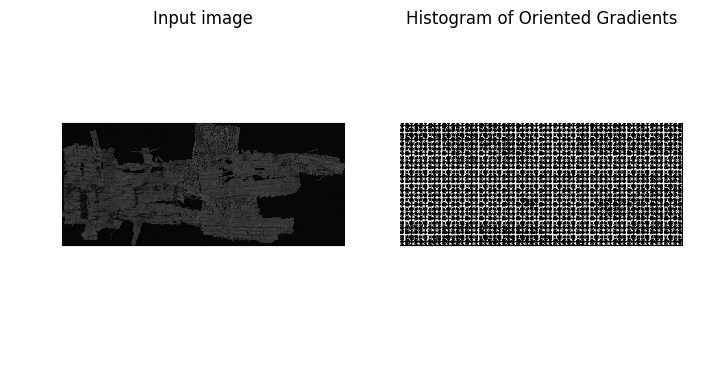

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import numpy as np

from skimage.feature import hog
from skimage import data, color, exposure

def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val


def crop_thresholded(image, crop_val=50):
    temp = crop(image, 600, 4300, 1000, 6000)
    temp = thresholded(temp, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    temp = crop(image, 600+ymin, 600+ymax, 1000+xmin, 1000+xmax)
    return temp


def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
# img = data.moon()
img = pltimg.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/jm_4a36716c764b6d6b4c442f464b3342347436653838673d3d/P598-Fg009-R/P598-Fg009-R-C01-R01-D07012014-T124136-LR445__001.jpg")
image = crop_thresholded(img)

# image = color.rgb2gray(data.astronaut())

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()